In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [2]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, multiply, Add, Reshape, Activation

def channel_attention(inputs, ratio=8):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(int(inputs.shape[-1]) // 8, activation='relu')(x)
    x = Dense(int(inputs.shape[-1]))(x)
    x = Activation('sigmoid')(x)
    x = Reshape((1, 1, inputs.shape[-1]))(x)
    return multiply([inputs, x])

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

#           ResNet50 / VGG16,   None / 'imagenet'
resnet_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# for layer in resnet_model.layers:
#     layer.trainable = False


x = resnet_model.output
x = channel_attention(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) # Binary class Real - Fake

model = Model(inputs=resnet_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    # steps_per_epoch=train_data.samples // train_data.batch_size,
    # validation_steps=val_data.samples // val_data.batch_size,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725084368.965835      88 service.cc:145] XLA service 0x7fa57c003510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725084368.965904      88 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725084368.965910      88 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725084433.995399      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1489s 906ms/step - accuracy: 0.6455 - loss: 0.5638 - val_accuracy: 0.9733 - val_loss: 0.0731
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1359s 844ms/step - accuracy: 0.9753 - loss: 0.0669 - val_accuracy: 0.9880 - val_loss: 0.0316
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1318s 843ms/step - accuracy: 0.9904 - loss: 0.0267 - val_accuracy: 0.9903 - val_loss: 0.0261
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1316s 841ms/step - accuracy: 0.9945 - loss: 0.0152 - val_accuracy: 0.9935 - val_loss: 0.0188
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1316s 841ms/step - accuracy: 0.9964 - loss: 0.0110 - val_accuracy: 0.9925 - val_loss: 0.0224
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1315s 841ms/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9926 - val_loss: 0.0234
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1315s 840ms/step - accuracy: 0.9974 - loss: 0.0072 - val_accuracy: 0.9875 - val_loss: 0.0361
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1314s 839ms/step - accur

In [5]:
# test set accuracy
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 454ms/step - accuracy: 0.9972 - loss: 0.0081
Test Accuracy: 99.80%


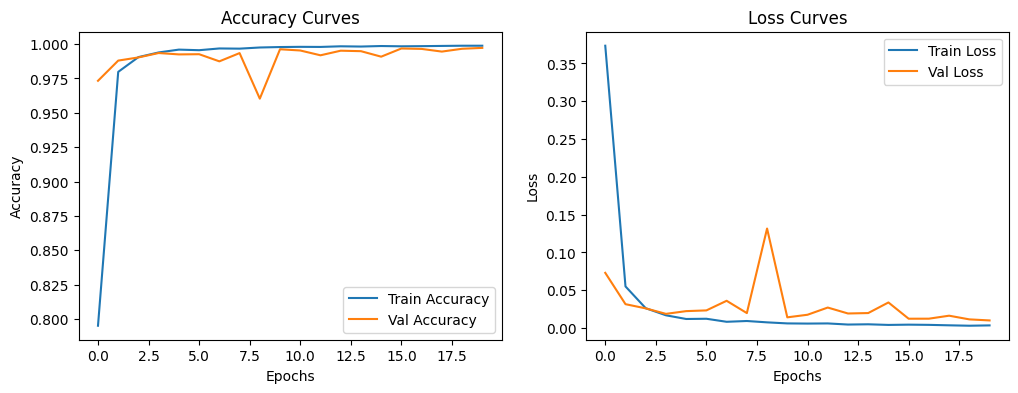

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig("acc.pdf")
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.pdf")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step


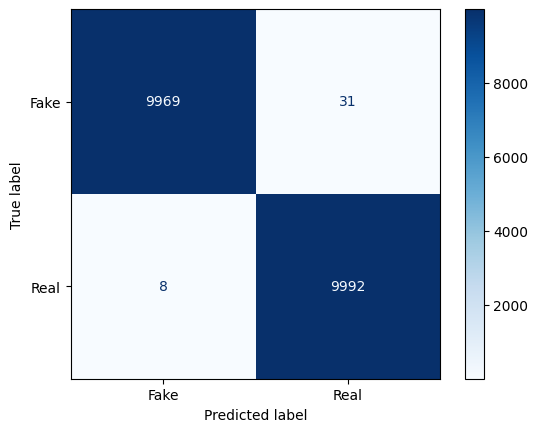

In [7]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(test_data, verbose=1)

y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = test_data.labels[:len(y_pred)]

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
cmd.plot(cmap=plt.cm.Blues)
plt.savefig("cm.pdf")
plt.show()

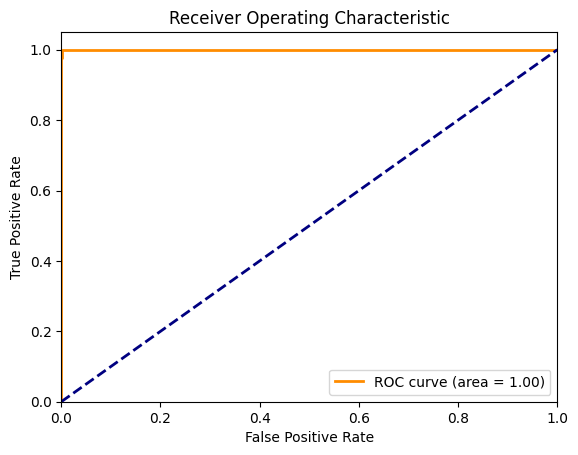

In [8]:
from sklearn.metrics import roc_curve, auc

# AUC-ROC Curve
# y_pred_prob = model.predict(test_data)
fpr, tpr, thresholds = roc_curve(test_data.labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("roc_auc.pdf")
plt.show()

In [ ]:
# model.save('realfake_model')
model.save('realfake_model.h5')

# model_json = model.to_json()
# with open("model_architecture.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model_weights.h5")

In [ ]:
# Load the model architecture and weights
# with open('model_architecture.json', 'r') as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# loaded_model.load_weights('model_weights.h5')

In [ ]:
# import seaborn as sns
# from tensorflow.keras.preprocessing import image

# # last_conv_layer = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
# last_conv_layer = model.get_layer('conv5_block3_out')

# grad_model = tf.keras.models.Model(
#     [model.inputs],
#     [last_conv_layer.output, model.output]
# )

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         loss = predictions[:, 0]

#     grads = tape.gradient(loss, conv_outputs)[0]

#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

#     conv_outputs = conv_outputs[0]
#     heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     heatmap = np.maximum(heatmap, 0)
#     heatmap /= tf.reduce_max(heatmap)

#     return heatmap.numpy()

# def display_gradcam(img, heatmap, alpha=0.4):
#     img = np.array(img)
#     heatmap = np.uint8(255 * heatmap)
#     jet = plt.cm.get_cmap("jet")
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]
#     jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     plt.imshow(img)
#     plt.title('Original Image')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(superimposed_img)
#     plt.title('Grad-CAM')
#     plt.axis('off')

#     plt.show()

# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg'  # a test image path
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array = img_array / 255.0

# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer.name)
# display_gradcam(img, heatmap)

# img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/008BYSE725.jpg'  # a test image path
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array = img_array / 255.0

# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer.name)
# display_gradcam(img, heatmap)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from tensorflow.keras.applications.resnet50 import preprocess_input


# def extract_features(model, datagen, batch_size=32):
#     features = []
#     labels = []
    
#     for data_batch, label_batch in datagen.flow(train_data, batch_size=batch_size, shuffle=False):
#         feature_batch = model.predict(data_batch)
#         features.append(feature_batch)
#         labels.append(label_batch)
#         if len(features) * batch_size >= datagen.samples:
#             break

#     return np.vstack(features), np.vstack(labels)

# features, labels = extract_features(model, train_datagen)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# features_tsne = tsne.fit_transform(features)

# # Plot the t-SNE results
# plt.figure(figsize=(10, 7))
# plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
# plt.colorbar()
# plt.title('t-SNE Visualization of Extracted Features')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.show()
